# Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import pathlib
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

# Data Load

In [4]:
splits=('train[:70%]','train[70%:90%]', 'train[90%:]')
(train, val, test), metadata = tfds.load(name='eurosat',
                                          as_supervised=True,
                                          split=splits,
                                          with_info=True)

# Data Augmentation

In [5]:
img_height = 64
img_width = 64

def preprocess(image, label):
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.keras.applications.resnet.preprocess_input(image)  # Normalize for ResNet50
    return image, label

def augment(image, label):
    image, label = preprocess(image, label)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32

train = (
    train
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val = (
    val
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test = (
    test
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# Model

In [7]:
num_classes = 10

# 사전학습된 ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# 기존 모델의 모든 레이어를 동결
base_model.trainable = False

# EuroSAT 분류를 위한 레이어 추가
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [9]:
history = model.fit(
    train,
    validation_data=val,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
591/591 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.7222 - loss: 1.0619 - val_accuracy: 0.9052 - val_loss: 0.3442
Epoch 2/100
591/591 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8975 - loss: 0.3826 - val_accuracy: 0.9189 - val_loss: 0.2951
Epoch 3/100
591/591 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9030 - loss: 0.3399 - val_accuracy: 0.9176 - val_loss: 0.3236
Epoch 4/100
591/591 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9145 - loss: 0.3103 - val_accuracy: 0.9217 - val_loss: 0.3041
Epoch 5/100
591/591 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9151 - loss: 0.3177 - val_accuracy: 0.9111 - val_loss: 0.3253
Epoch 6/100
591/591 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9144 - loss: 0.3007 - val_accuracy: 0.9259 - val_loss: 0.2829
Epoch 7/100
591/591 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9196 - loss: 0.2852 - val_accuracy: 0.9233 - val_loss: 0.3218
Epoch 8/100
591/591 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9152 - loss: 0

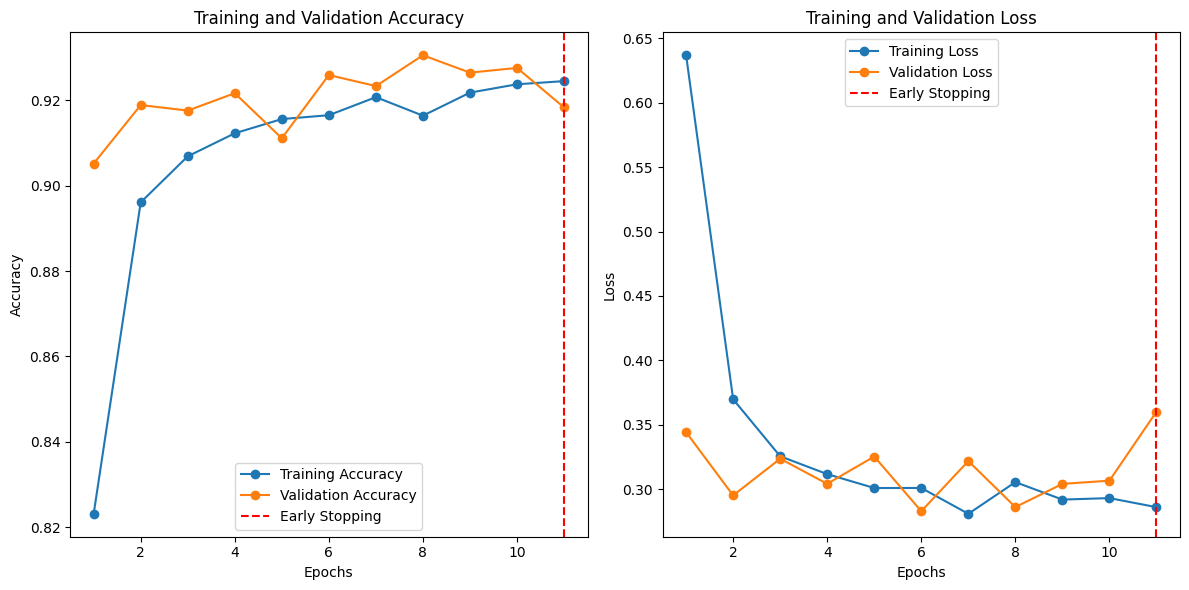

In [10]:
def plot_early_stopping(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    if acc and val_acc:
        plt.plot(epochs, acc, label='Training Accuracy', marker='o')
        plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
        plt.axvline(len(loss), color='red', linestyle='--', label='Early Stopping')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.axvline(len(loss), color='red', linestyle='--', label='Early Stopping')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_early_stopping(history)

Epoch 1/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 117s 106ms/step - accuracy: 0.8527 - loss: 0.5928 - val_accuracy: 0.9489 - val_loss: 0.1521
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 90s 61ms/step - accuracy: 0.9346 - loss: 0.2130 - val_accuracy: 0.9585 - val_loss: 0.1350
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.9506 - loss: 0.1647 - val_accuracy: 0.9598 - val_loss: 0.1400
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - accuracy: 0.9619 - loss: 0.1203 - val_accuracy: 0.9598 - val_loss: 0.1302
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 39s 60ms/step - accuracy: 0.9633 - loss: 0.1154 - val_accuracy: 0.9591 - val_loss: 0.1261
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9662 - loss: 0.1182 - val_accuracy: 0.9528 - val_loss: 0.1621
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - accuracy: 0.9715 - loss: 0.0929 - val_accuracy: 0.9687 - val_loss: 0.1091
Epoch 8/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.9755 - loss: 0.0724 

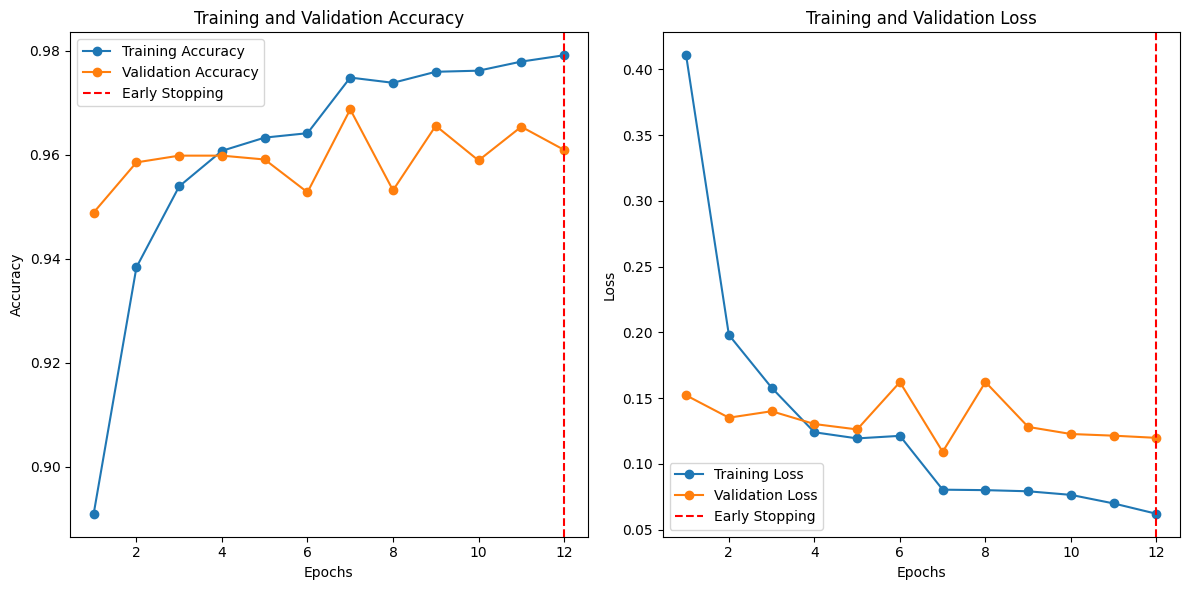

In [11]:
# Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 작은 학습률
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train,
    validation_data=val,
    epochs=50,
    callbacks=[early_stopping]
)

plot_early_stopping(history_fine)

# Result


In [13]:
test_loss, test_accuracy = model.evaluate(test, verbose=2)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

85/85 - 2s - 18ms/step - accuracy: 0.9696 - loss: 0.0876
Test Loss: 0.0876
Test Accuracy: 0.9696
